In [ ]:
!pip install -Uqq accelerate diffusers["training"] transformers ftfy "ipywidgets>=7,<8" fastcore bitsandbytes

In [ ]:
import argparse, itertools, math, os, random, PIL
import numpy as np, torch, torch.nn.functional as F, torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from PIL.Image import Resampling
from torchvision import transforms
from tqdm.auto import tqdm

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import fastcore.all as fc
from huggingface_hub import notebook_login
from pathlib import Path

import torchvision.transforms.functional as tf
import accelerate

In [ ]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [ ]:
model_nm = "CompVis/stable-diffusion-v1-4"

In [ ]:
urls = [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

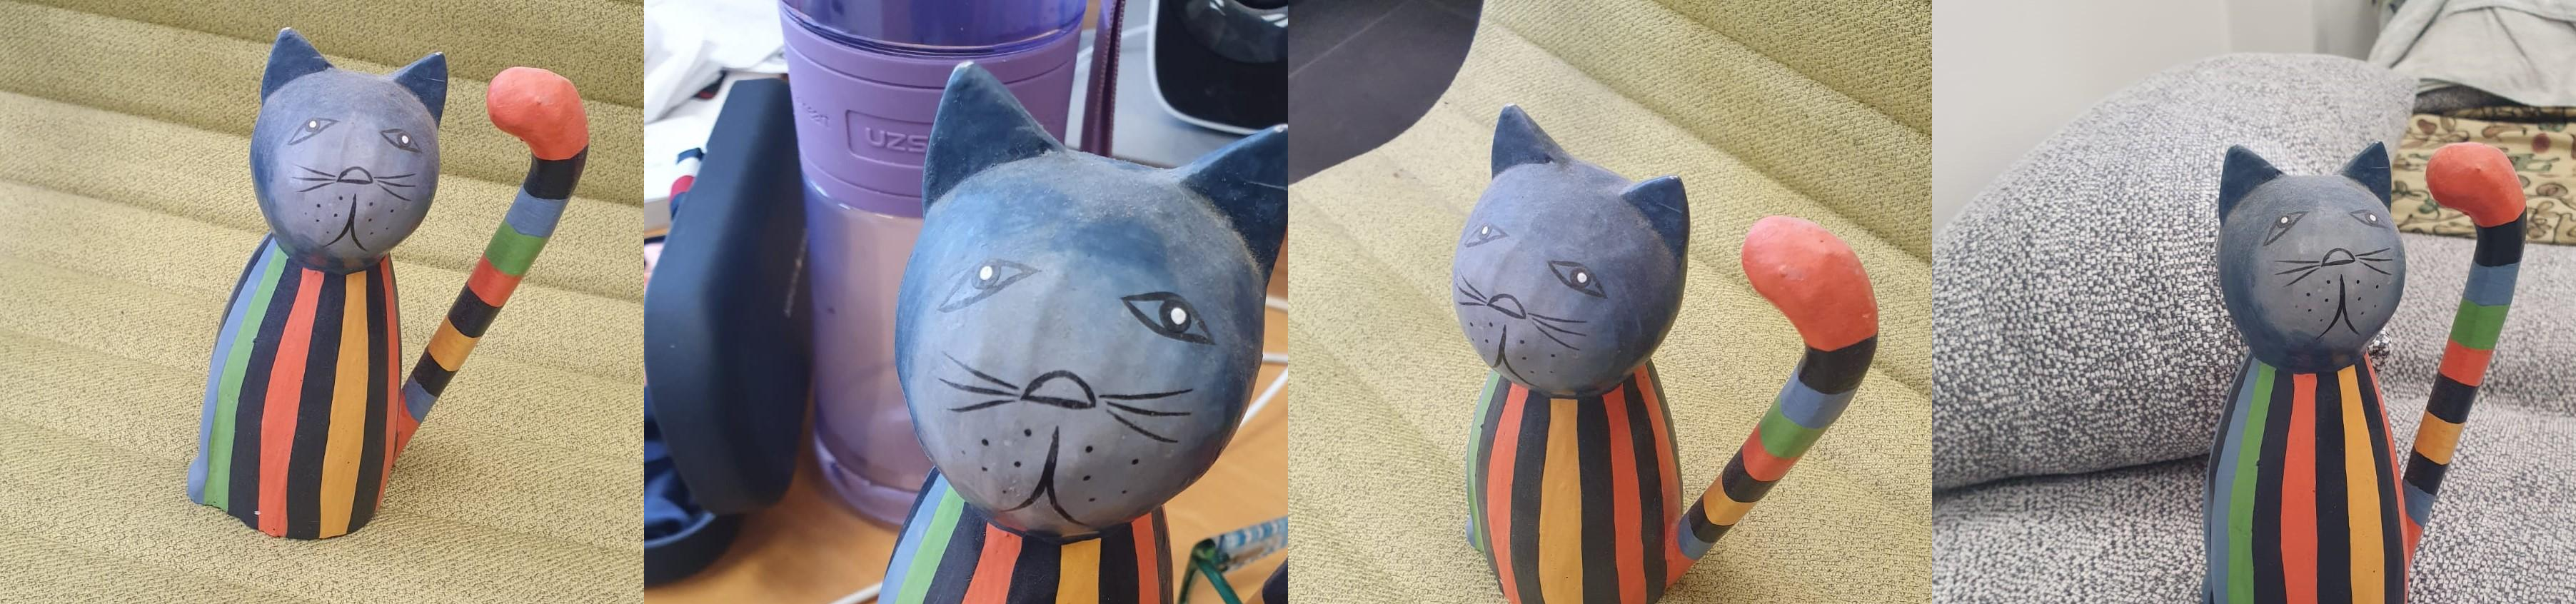

In [ ]:
import requests
from io import BytesIO

save_path = Path.home()/"my_concept"
save_path.mkdir(exist_ok=True)
images = []
for i,url in enumerate(urls):
    p = save_path/f"{i}.jpeg"
    if p.exists(): image = Image.open(p)
    else:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image.save(p)
    images.append(image)

image_grid(images, 1, len(images))

In [ ]:
# path = Path.home()/'Downloads/photos/'
# paths = list(path.iterdir())
# images = [Image.open(p).resize((512, 512), resample=Resampling.BICUBIC).convert("RGB") for p in paths]

In [ ]:
what_to_teach = "object"
placeholder_token = "<tiny>"
initializer_token = "teddy"

In [ ]:
templates = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [ ]:
class TextualInversionDataset:
    def __init__(self, tokenizer, images, learnable_property="object", size=512,
                 repeats=100, interpolation=Resampling.BICUBIC, flip_p=0.5, set="train", placeholder_token="*"):
        fc.store_attr()
        self.num_images = len(images)
        if set == "train": self._length = self.num_images * repeats
        self.templates = style_templates if learnable_property == "style" else templates
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self): return self.num_images

    def __getitem__(self, i):
        image = tf.to_tensor(self.images[i%self.num_images])*2-1
        text = random.choice(self.templates).format(self.placeholder_token)
        ids = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt")
        return dict(input_ids=ids.input_ids[0], pixel_values=image)

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(model_nm, subfolder="tokenizer", torch_type=torch.float16, revision="fp16")
# TODO: torch_type not supported?
text_encoder = CLIPTextModel.from_pretrained(model_nm, subfolder="text_encoder", revision="fp16")
vae = AutoencoderKL.from_pretrained(model_nm, subfolder="vae", torch_type=torch.float16, revision="fp16")
unet = UNet2DConditionModel.from_pretrained(model_nm, subfolder="unet", torch_type=torch.float16, revision="fp16")

In [ ]:
num_added_tokens = tokenizer.add_tokens(placeholder_token)
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [ ]:
# Freeze all parameters except for the token embeddings in text encoder
tm = text_encoder.text_model
for o in (vae, unet, tm.encoder, tm.final_layer_norm, tm.embeddings.position_embedding):
    for p in o.parameters(): p.requires_grad = False

In [ ]:
train_dataset = TextualInversionDataset(
    images=images, tokenizer=tokenizer, size=512, placeholder_token=placeholder_token,
    repeats=100, learnable_property=what_to_teach, set="train")

In [ ]:
def create_dataloader(bs=1): return DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [ ]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
import bitsandbytes as bnb

In [ ]:
def training_function(text_encoder, vae, unet, train_batch_size, gradient_accumulation_steps,
                      lr, max_train_steps, scale_lr, output_dir):
    accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps, mixed_precision='fp16')
    train_dataloader = create_dataloader(train_batch_size)
    if scale_lr: lr = (lr * gradient_accumulation_steps * train_batch_size * accelerator.num_processes)
    #optimizer = torch.optim.AdamW(text_encoder.get_input_embeddings().parameters(), lr=lr)
    optimizer = bnb.optim.AdamW8bit(text_encoder.get_input_embeddings().parameters(), lr=lr)
    text_encoder, optimizer, train_dataloader = accelerator.prepare(text_encoder, optimizer, train_dataloader)
    vae.to(accelerator.device).eval()
    unet.to(accelerator.device).eval()

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach() * 0.18215
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # We only want to optimize the concept embeddings
                grads = text_encoder.get_input_embeddings().weight.grad
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            progress_bar.set_postfix(loss=loss.detach().item())
            if global_step >= max_train_steps: break

    pipeline = StableDiffusionPipeline(
        text_encoder=accelerator.unwrap_model(text_encoder),
        vae=vae, unet=unet, tokenizer=tokenizer,
        scheduler=PNDMScheduler(
            beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True),
        safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
        feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))
    pipeline.save_pretrained(output_dir)
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [ ]:
from functools import partial
f = partial(training_function, train_batch_size=1, gradient_accumulation_steps=2, lr=5e-04,
      max_train_steps=3000, scale_lr=True, output_dir="sd-concept-output")

In [ ]:
import accelerate
torch.manual_seed(42)
accelerate.notebook_launcher(f, args=(text_encoder, vae, unet), num_processes=1)

Launching training on one GPU.


  0%|          | 0/3000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 4.12 GiB (GPU 0; 15.90 GiB total capacity; 9.37 GiB already allocated; 2.29 GiB free; 12.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF